# TimeQuant Enhanced Quickstart

This notebook demonstrates the core functionality of TimeQuant tokenizers for streaming time series tokenization with advanced visualizations.

TimeQuant provides:
- **GQTokenizer**: Univariate Gaussian-quantile tokenization
- **MultiGQTokenizer**: Multivariate tokenization with codebook reduction
- **Streaming**: Online statistics with O(1) memory per dimension
- **Fast**: Binary search tokenization, vectorized operations

In [6]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pandas as pd
from timequant.tokenizers.gq_tokenizer import GQTokenizer
from timequant.tokenizers.multi_gq_tokenizer import MultiGQTokenizer

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

## 1. Univariate Tokenization with Advanced Visualization

In [7]:
def generate_complex_ts(n_samples=1000, components=3):
    """Generate a complex time series with multiple components"""
    t = np.arange(n_samples)
    
    # Multiple frequency components
    trend = 0.001 * t
    seasonal1 = 2 * np.sin(2 * np.pi * t / 50)
    seasonal2 = 1.5 * np.cos(2 * np.pi * t / 200)
    noise = np.random.normal(0, 0.5, n_samples)
    
    # Random walk component
    random_walk = np.cumsum(np.random.normal(0, 0.2, n_samples))
    
    return trend + seasonal1 + seasonal2 + random_walk + noise

# Generate complex time series
ts_complex = generate_complex_ts(2000)
print(f"Time series shape: {ts_complex.shape}")
print(f"Time series stats: mean={ts_complex.mean():.3f}, std={ts_complex.std():.3f}")

Time series shape: (2000,)
Time series stats: mean=0.247, std=2.707


In [8]:
# Tokenize the complex time series
vocab_size = 32
tokenizer = GQTokenizer(V=vocab_size)

tokens = []
means = []
stds = []

for t, x_t in enumerate(ts_complex):
    tokenizer.update(x_t)
    token = tokenizer.encode(x_t)
    tokens.append(token)
    means.append(tokenizer.stats.mean)
    stds.append(tokenizer.stats.std)

tokens = np.array(tokens)
means = np.array(means)
stds = np.array(stds)

print(f"Tokenization complete! Generated {len(tokens)} tokens")
print(f"Vocabulary utilization: {tokenizer.get_vocab_utilization(tokens):.3f}")

Tokenization complete! Generated 2000 tokens
Vocabulary utilization: 1.000


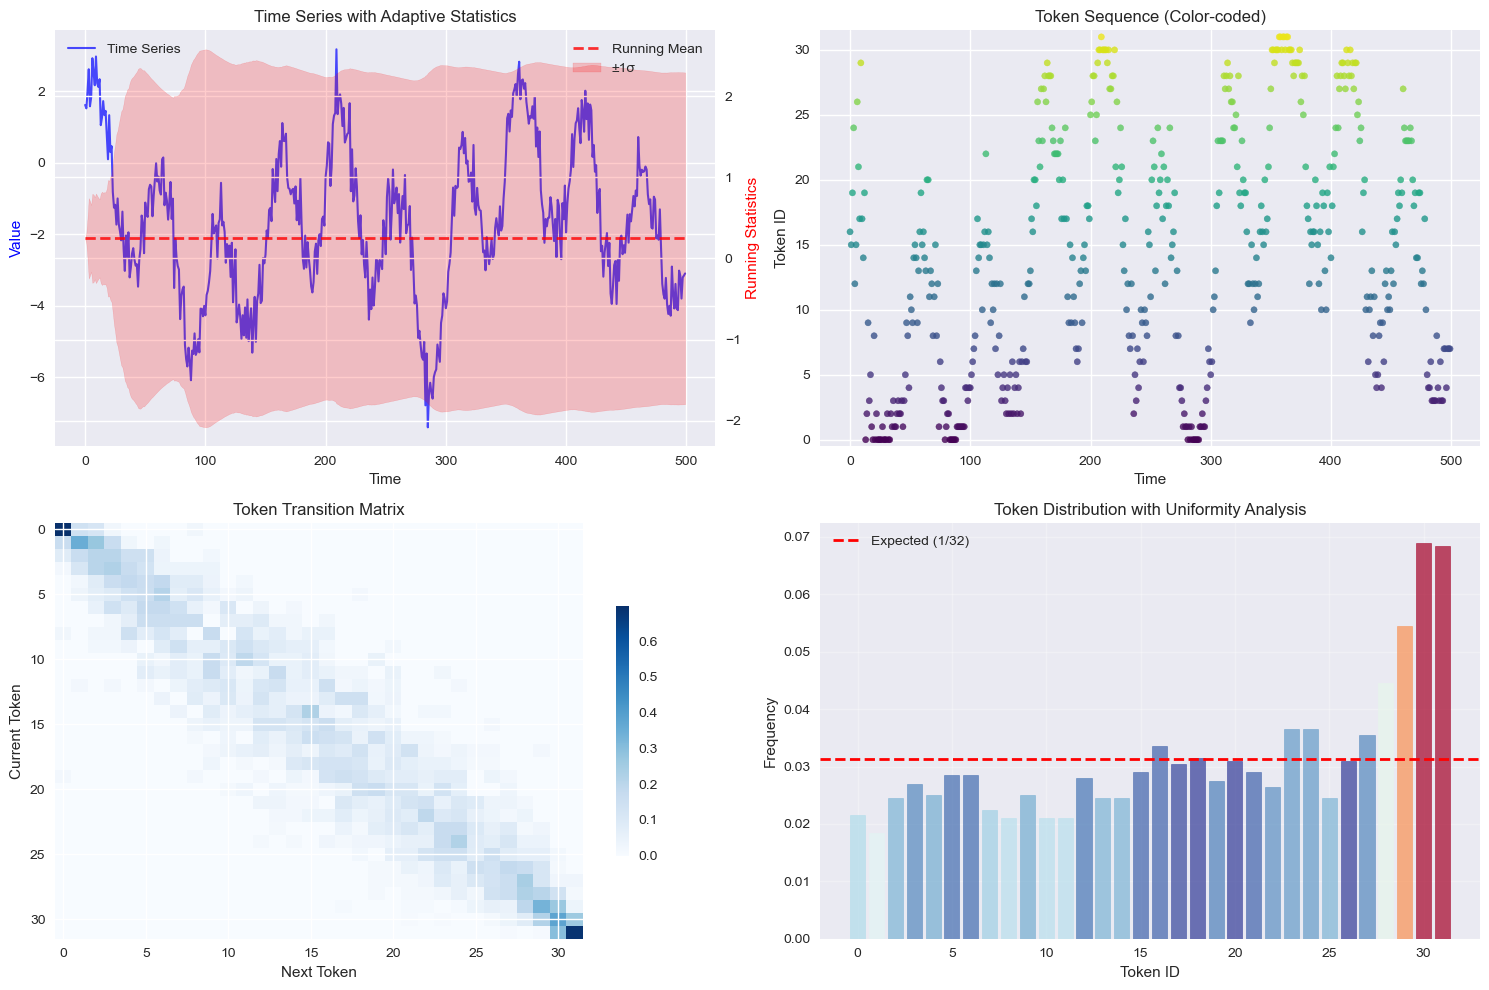


Tokenization Quality Metrics:
Entropy: 4.911 bits
Max possible entropy: 5.000 bits
Uniformity score: 0.982 (1.0 = perfect uniform)


In [9]:
# Advanced visualization of tokenization process
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
time_range = slice(0, 500)

# Original time series with adaptive statistics overlay
ax1 = axes[0, 0]
ax1.plot(ts_complex[time_range], 'b-', alpha=0.7, linewidth=1.5, label='Time Series')
ax1_twin = ax1.twinx()
ax1_twin.plot(means[time_range], 'r--', alpha=0.8, linewidth=2, label='Running Mean')
ax1_twin.fill_between(range(len(means[time_range])), 
                      means[time_range] - stds[time_range], 
                      means[time_range] + stds[time_range], 
                      alpha=0.2, color='red', label='±1σ')
ax1.set_title('Time Series with Adaptive Statistics')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value', color='blue')
ax1_twin.set_ylabel('Running Statistics', color='red')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Token sequence with color mapping
ax2 = axes[0, 1]
colors = plt.cm.viridis(tokens[time_range] / vocab_size)
ax2.scatter(range(len(tokens[time_range])), tokens[time_range], 
           c=colors, s=20, alpha=0.8)
ax2.set_title('Token Sequence (Color-coded)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Token ID')
ax2.set_ylim(-0.5, vocab_size - 0.5)

# Token transition heatmap
ax3 = axes[1, 0]
transition_matrix = np.zeros((vocab_size, vocab_size))
for i in range(len(tokens) - 1):
    transition_matrix[tokens[i], tokens[i+1]] += 1
    
# Normalize rows
row_sums = transition_matrix.sum(axis=1)
transition_matrix = transition_matrix / (row_sums[:, np.newaxis] + 1e-10)

im = ax3.imshow(transition_matrix, cmap='Blues', aspect='auto')
ax3.set_title('Token Transition Matrix')
ax3.set_xlabel('Next Token')
ax3.set_ylabel('Current Token')
plt.colorbar(im, ax=ax3, shrink=0.6)

# Distribution analysis
ax4 = axes[1, 1]
token_counts = np.bincount(tokens, minlength=vocab_size)
token_freqs = token_counts / len(tokens)
expected_freq = 1.0 / vocab_size

bars = ax4.bar(range(vocab_size), token_freqs, alpha=0.7, color='skyblue', 
               edgecolor='navy', linewidth=0.5)
ax4.axhline(expected_freq, color='red', linestyle='--', linewidth=2, 
           label=f'Expected (1/{vocab_size})')

# Color bars by frequency deviation
for i, bar in enumerate(bars):
    deviation = abs(token_freqs[i] - expected_freq)
    bar.set_color(plt.cm.RdYlBu_r(deviation * vocab_size))

ax4.set_title('Token Distribution with Uniformity Analysis')
ax4.set_xlabel('Token ID')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display uniformity metrics
entropy = -np.sum(token_freqs * np.log2(token_freqs + 1e-10))
max_entropy = np.log2(vocab_size)
uniformity = entropy / max_entropy

print(f"\nTokenization Quality Metrics:")
print(f"Entropy: {entropy:.3f} bits")
print(f"Max possible entropy: {max_entropy:.3f} bits")
print(f"Uniformity score: {uniformity:.3f} (1.0 = perfect uniform)")

## 2. Multivariate Time Series Analysis with PCA

In [10]:
def generate_correlated_multivariate_ts(n_samples=1000, n_dims=4, correlation_strength=0.3):
    """Generate correlated multivariate time series with different dynamics"""
    # Create correlation matrix
    rho = correlation_strength
    Sigma = np.eye(n_dims) * (1 - rho) + np.ones((n_dims, n_dims)) * rho
    
    # Different dynamics for each dimension
    t = np.arange(n_samples)
    X = np.zeros((n_samples, n_dims))
    
    # Dimension 1: Trending with seasonality
    X[:, 0] = 0.001 * t + 2 * np.sin(2 * np.pi * t / 100) + np.random.normal(0, 0.5, n_samples)
    
    # Dimension 2: Mean-reverting process
    for i in range(1, n_samples):
        X[i, 1] = 0.95 * X[i-1, 1] + np.random.normal(0, 0.3)
    
    # Dimension 3: Random walk with drift
    X[:, 2] = np.cumsum(np.random.normal(0.01, 0.4, n_samples))
    
    # Dimension 4: High-frequency oscillations
    X[:, 3] = 3 * np.sin(2 * np.pi * t / 20) + 1.5 * np.cos(2 * np.pi * t / 30) + np.random.normal(0, 0.3, n_samples)
    
    # Apply correlation structure
    L = np.linalg.cholesky(Sigma)
    noise = np.random.randn(n_samples, n_dims) @ L.T * 0.2
    
    return X + noise

# Generate multivariate time series
mv_ts = generate_correlated_multivariate_ts(1500, 4, 0.4)
print(f"Multivariate series shape: {mv_ts.shape}")
print(f"Correlation matrix:")
print(np.corrcoef(mv_ts.T))

Multivariate series shape: (1500, 4)
Correlation matrix:
[[ 1.         -0.05249402  0.20704166  0.00334329]
 [-0.05249402  1.         -0.08189885 -0.02368394]
 [ 0.20704166 -0.08189885  1.         -0.01286955]
 [ 0.00334329 -0.02368394 -0.01286955  1.        ]]


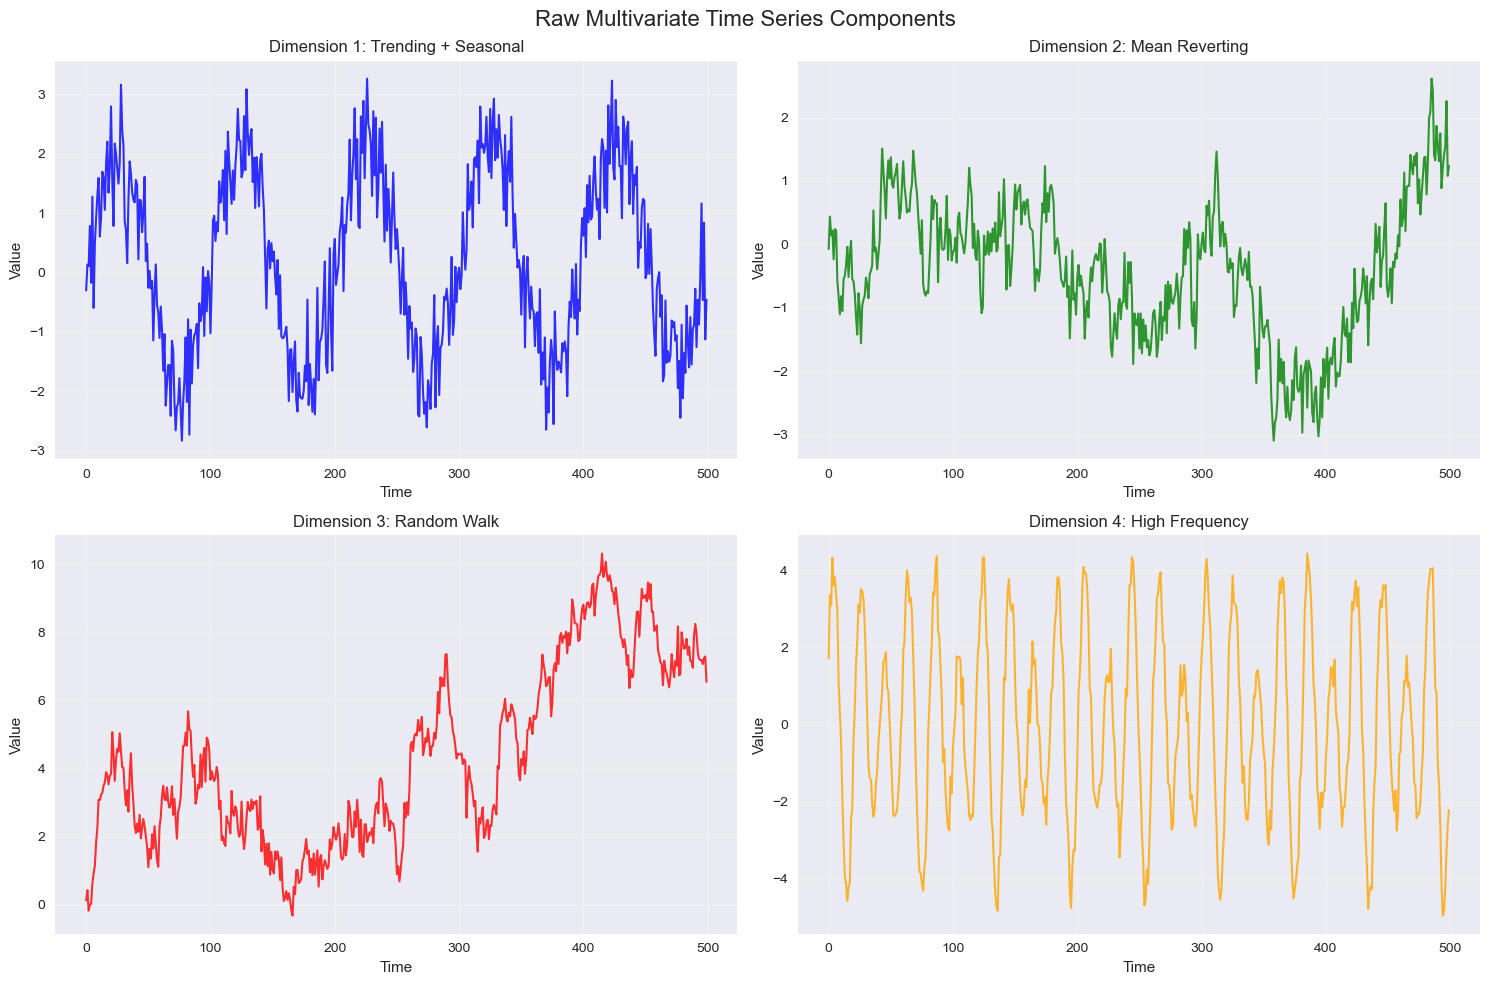

In [11]:
# Visualize the raw multivariate time series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

dim_names = ['Trending + Seasonal', 'Mean Reverting', 'Random Walk', 'High Frequency']
colors = ['blue', 'green', 'red', 'orange']

for i in range(4):
    axes[i].plot(mv_ts[:500, i], color=colors[i], linewidth=1.5, alpha=0.8)
    axes[i].set_title(f'Dimension {i+1}: {dim_names[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Raw Multivariate Time Series Components', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
# Tokenize multivariate time series
mv_tokenizer = MultiGQTokenizer(D=4, V_dim=4, V=64)

# Phase 1: Update statistics and collect vector codes
print("Phase 1: Collecting vector codes...")
vector_codes = []
original_values = []

for t, x_vec in enumerate(mv_ts):
    mv_tokenizer.update(x_vec)
    code = mv_tokenizer.encode_vector_code(x_vec)
    vector_codes.append(code)
    original_values.append(x_vec)
    
    if t % 300 == 0:
        print(f"  Processed {t} samples...")

vector_codes = np.array(vector_codes)
original_values = np.array(original_values)

print(f"\nCollected {len(vector_codes)} vector codes")
print(f"Per-dimension utilization: {mv_tokenizer.get_per_dim_utilization(vector_codes)}")

Phase 1: Collecting vector codes...
  Processed 0 samples...
  Processed 300 samples...
  Processed 600 samples...
  Processed 900 samples...
  Processed 1200 samples...

Collected 1500 vector codes
Per-dimension utilization: [1. 1. 1. 1.]


In [13]:
# Phase 2: Fit codebook and get final tokens
print("Phase 2: Fitting codebook...")
mv_tokenizer.fit_codebook(vector_codes, seed=42)

final_tokens = []
for x_vec in mv_ts:
    token = mv_tokenizer.encode(x_vec)
    final_tokens.append(token)

final_tokens = np.array(final_tokens)
print(f"\nFinal tokenization complete!")
print(f"Final vocab utilization: {mv_tokenizer.get_vocab_utilization(final_tokens):.3f}")

Phase 2: Fitting codebook...

Final tokenization complete!
Final vocab utilization: 1.000


## 3. Advanced PCA Analysis and Visualization

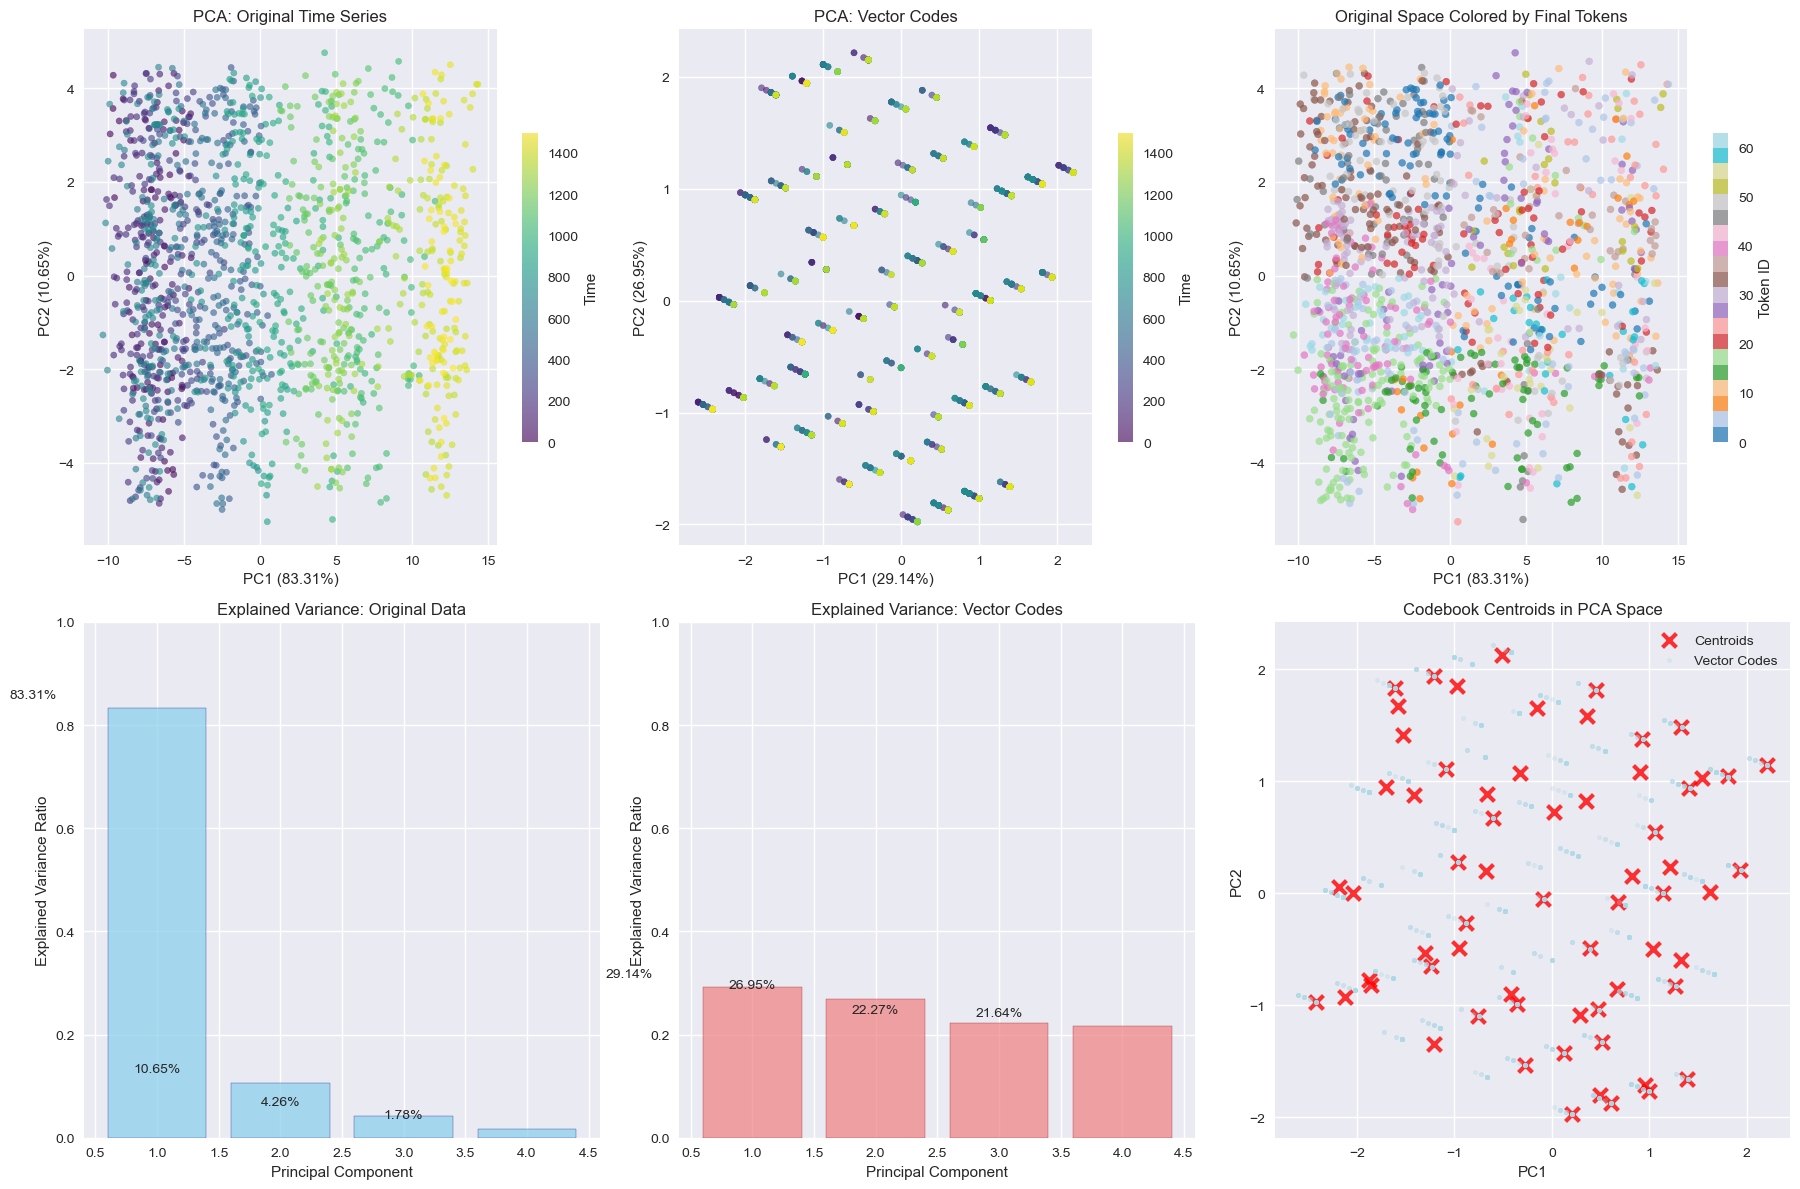

In [14]:
# PCA analysis of original data vs tokenized representations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# PCA of original time series
pca_original = PCA()
original_pca = pca_original.fit_transform(mv_ts)

# PCA of vector codes
pca_codes = PCA()
codes_pca = pca_codes.fit_transform(vector_codes.astype(float))

# Create time-based color mapping
time_colors = np.arange(len(mv_ts))

# Original data PCA scatter
scatter1 = axes[0, 0].scatter(original_pca[:, 0], original_pca[:, 1], 
                             c=time_colors, cmap='viridis', alpha=0.6, s=20)
axes[0, 0].set_title('PCA: Original Time Series')
axes[0, 0].set_xlabel(f'PC1 ({pca_original.explained_variance_ratio_[0]:.2%})')
axes[0, 0].set_ylabel(f'PC2 ({pca_original.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter1, ax=axes[0, 0], shrink=0.6, label='Time')

# Vector codes PCA scatter
scatter2 = axes[0, 1].scatter(codes_pca[:, 0], codes_pca[:, 1], 
                             c=time_colors, cmap='viridis', alpha=0.6, s=20)
axes[0, 1].set_title('PCA: Vector Codes')
axes[0, 1].set_xlabel(f'PC1 ({pca_codes.explained_variance_ratio_[0]:.2%})')
axes[0, 1].set_ylabel(f'PC2 ({pca_codes.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter2, ax=axes[0, 1], shrink=0.6, label='Time')

# Final tokens colored by token ID
scatter3 = axes[0, 2].scatter(original_pca[:, 0], original_pca[:, 1], 
                             c=final_tokens, cmap='tab20', alpha=0.7, s=25)
axes[0, 2].set_title('Original Space Colored by Final Tokens')
axes[0, 2].set_xlabel(f'PC1 ({pca_original.explained_variance_ratio_[0]:.2%})')
axes[0, 2].set_ylabel(f'PC2 ({pca_original.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter3, ax=axes[0, 2], shrink=0.6, label='Token ID')

# Explained variance plots
axes[1, 0].bar(range(1, 5), pca_original.explained_variance_ratio_, 
              alpha=0.7, color='skyblue', edgecolor='navy')
axes[1, 0].set_title('Explained Variance: Original Data')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].set_ylim(0, 1)
for i, v in enumerate(pca_original.explained_variance_ratio_):
    axes[1, 0].text(i, v + 0.02, f'{v:.2%}', ha='center')

axes[1, 1].bar(range(1, 5), pca_codes.explained_variance_ratio_, 
              alpha=0.7, color='lightcoral', edgecolor='darkred')
axes[1, 1].set_title('Explained Variance: Vector Codes')
axes[1, 1].set_xlabel('Principal Component')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(pca_codes.explained_variance_ratio_):
    axes[1, 1].text(i, v + 0.02, f'{v:.2%}', ha='center')

# Codebook visualization
centroids = mv_tokenizer.codebook.centroids
if centroids is not None:
    centroids_pca = pca_codes.transform(centroids)
    axes[1, 2].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                      c='red', s=100, alpha=0.8, marker='x', linewidths=3, label='Centroids')
    axes[1, 2].scatter(codes_pca[:, 0], codes_pca[:, 1], 
                      c='lightblue', alpha=0.3, s=10, label='Vector Codes')
    axes[1, 2].set_title('Codebook Centroids in PCA Space')
    axes[1, 2].set_xlabel('PC1')
    axes[1, 2].set_ylabel('PC2')
    axes[1, 2].legend()

plt.tight_layout()
plt.show()

## 4. t-SNE Analysis for Non-linear Dimensionality Reduction

Computing t-SNE embeddings (this may take a moment)...


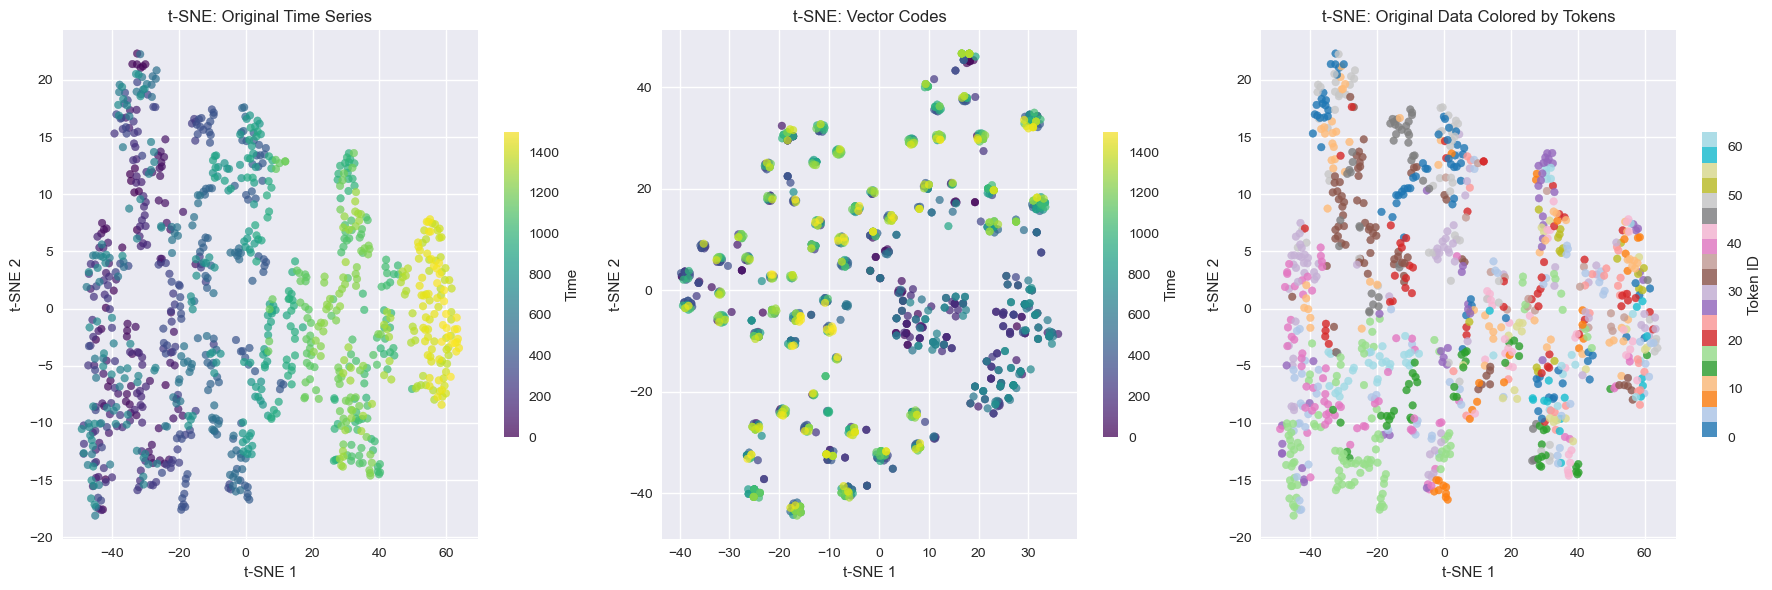


t-SNE reveals non-linear structure in the data that PCA might miss.


In [15]:
# Apply t-SNE to original data and vector codes
print("Computing t-SNE embeddings (this may take a moment)...")

# Sample data for t-SNE (it's computationally expensive)
sample_indices = np.random.choice(len(mv_ts), size=min(1000, len(mv_ts)), replace=False)
sample_indices.sort()

tsne_original = TSNE(n_components=2, random_state=42, perplexity=30)
original_tsne = tsne_original.fit_transform(mv_ts[sample_indices])

tsne_codes = TSNE(n_components=2, random_state=42, perplexity=30)
codes_tsne = tsne_codes.fit_transform(vector_codes[sample_indices].astype(float))

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# t-SNE of original data
scatter1 = axes[0].scatter(original_tsne[:, 0], original_tsne[:, 1], 
                          c=sample_indices, cmap='viridis', alpha=0.7, s=30)
axes[0].set_title('t-SNE: Original Time Series')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0], shrink=0.6, label='Time')

# t-SNE of vector codes
scatter2 = axes[1].scatter(codes_tsne[:, 0], codes_tsne[:, 1], 
                          c=sample_indices, cmap='viridis', alpha=0.7, s=30)
axes[1].set_title('t-SNE: Vector Codes')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
plt.colorbar(scatter2, ax=axes[1], shrink=0.6, label='Time')

# t-SNE colored by final tokens
scatter3 = axes[2].scatter(original_tsne[:, 0], original_tsne[:, 1], 
                          c=final_tokens[sample_indices], cmap='tab20', alpha=0.8, s=30)
axes[2].set_title('t-SNE: Original Data Colored by Tokens')
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')
plt.colorbar(scatter3, ax=axes[2], shrink=0.6, label='Token ID')

plt.tight_layout()
plt.show()

print("\nt-SNE reveals non-linear structure in the data that PCA might miss.")

## 5. Clustering Analysis in Token Space

Silhouette Score: 0.305


/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_9765/2460570676.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(times, mv_ts[time_window, i][mask],


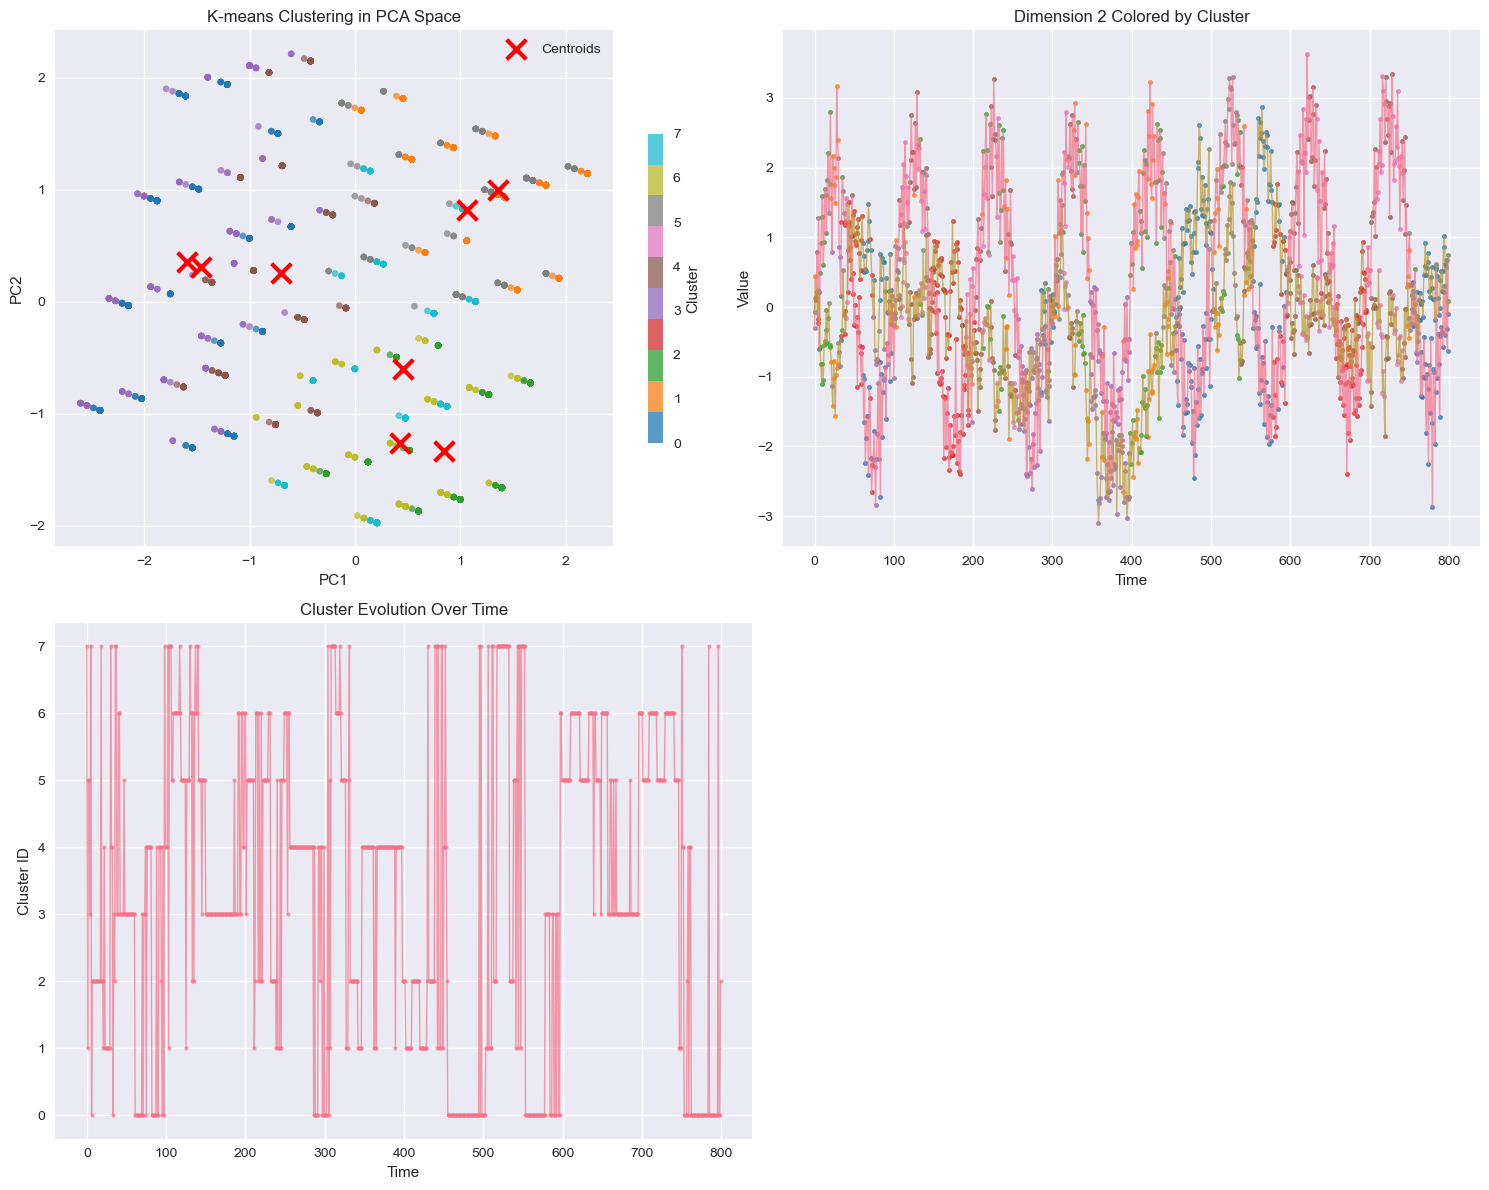


Cluster Statistics:
Cluster 0: 285 points (19.0%)
Cluster 1: 244 points (16.3%)
Cluster 2: 214 points (14.3%)
Cluster 3: 117 points (7.8%)
Cluster 4: 233 points (15.5%)
Cluster 5: 114 points (7.6%)
Cluster 6: 100 points (6.7%)
Cluster 7: 193 points (12.9%)


In [16]:
# Perform clustering analysis on the tokenized data
from sklearn.metrics import silhouette_score, adjusted_rand_score

# K-means clustering on vector codes
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vector_codes.astype(float))

# Calculate clustering metrics
silhouette = silhouette_score(vector_codes.astype(float), cluster_labels)
print(f"Silhouette Score: {silhouette:.3f}")

# Visualize clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Clustering in PCA space
scatter1 = axes[0, 0].scatter(codes_pca[:, 0], codes_pca[:, 1], 
                             c=cluster_labels, cmap='tab10', alpha=0.7, s=20)
# Plot cluster centers
centers_pca = pca_codes.transform(kmeans.cluster_centers_)
axes[0, 0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[0, 0].set_title('K-means Clustering in PCA Space')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].legend()
plt.colorbar(scatter1, ax=axes[0, 0], shrink=0.6, label='Cluster')

# Time series colored by cluster
time_window = slice(0, 800)
for i in range(4):
    ax = axes[0, 1] if i < 2 else axes[1, 1]
    if i < 2:
        ax.plot(mv_ts[time_window, i], alpha=0.7, linewidth=1)
        # Color by cluster membership
        for cluster_id in range(n_clusters):
            mask = (cluster_labels[time_window] == cluster_id)
            if np.any(mask):
                times = np.where(mask)[0]
                ax.scatter(times, mv_ts[time_window, i][mask], 
                          c=plt.cm.tab10(cluster_id), s=10, alpha=0.8)
        ax.set_title(f'Dimension {i+1} Colored by Cluster')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')

# Cluster transition analysis
axes[1, 0].plot(cluster_labels[time_window], 'o-', markersize=3, linewidth=1, alpha=0.7)
axes[1, 0].set_title('Cluster Evolution Over Time')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Cluster ID')
axes[1, 0].set_yticks(range(n_clusters))

# Remove empty subplot
axes[1, 1].remove()

plt.tight_layout()
plt.show()

# Cluster statistics
print("\nCluster Statistics:")
unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster_id}: {count} points ({count/len(cluster_labels)*100:.1f}%)")

## 6. Information Theory Analysis

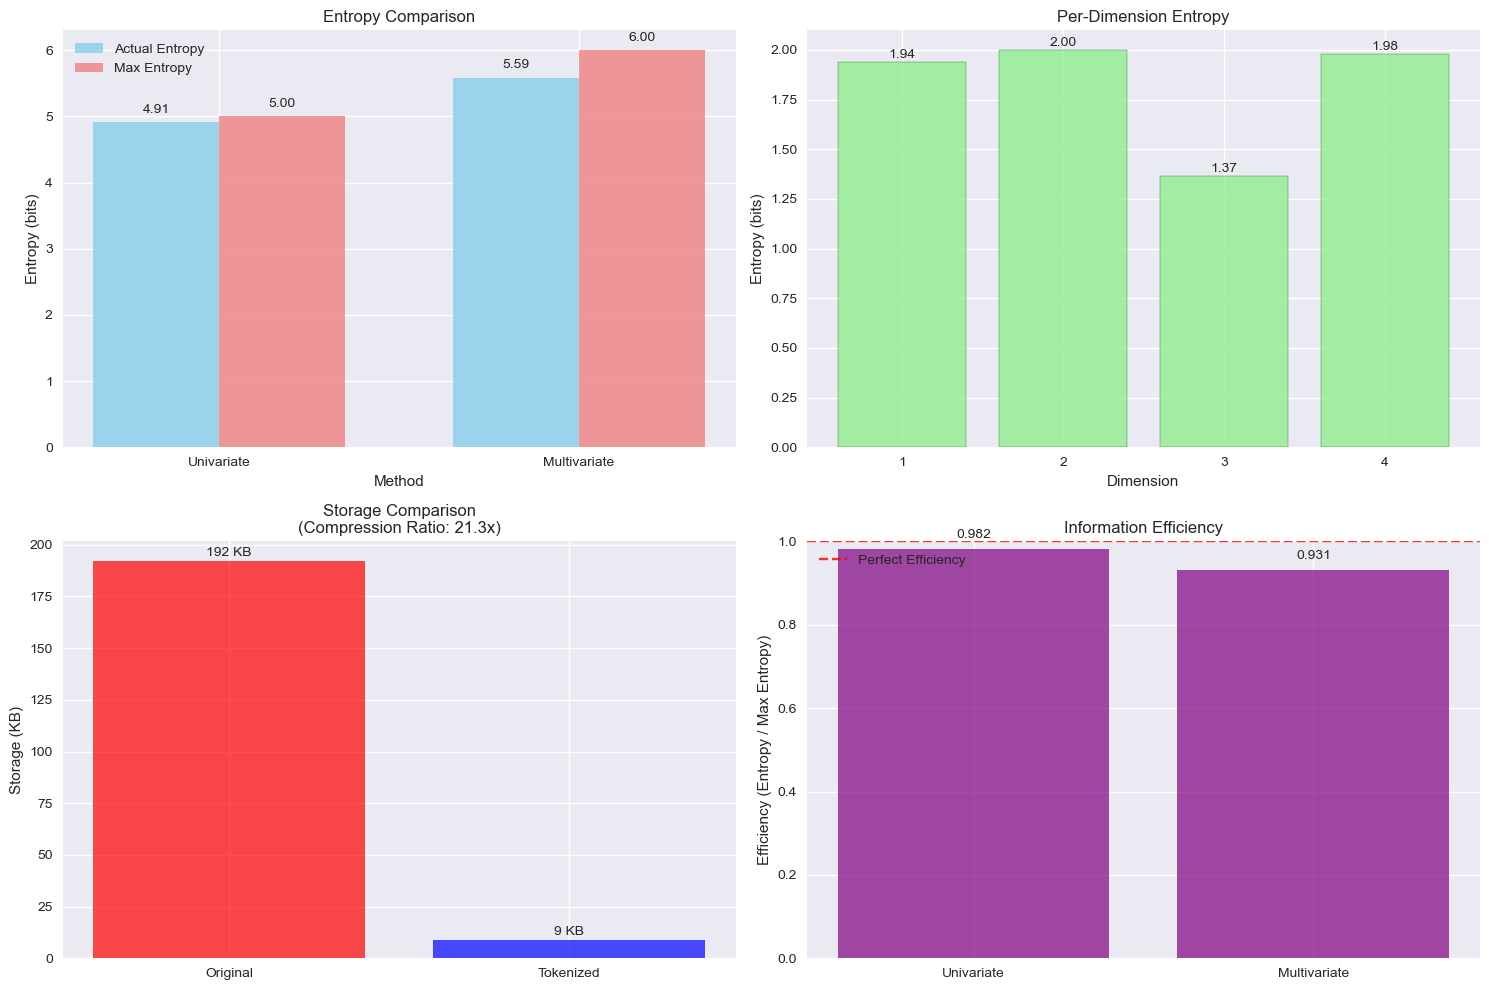


INFORMATION THEORY ANALYSIS SUMMARY
Univariate Tokenization:
  Entropy: 4.911 bits
  Efficiency: 0.982

Multivariate Tokenization:
  Entropy: 5.586 bits
  Efficiency: 0.931

Compression:
  Original size: 24.0 KB
  Tokenized size: 1.1 KB
  Compression ratio: 21.3x


In [17]:
# Calculate various information theory metrics
def calculate_entropy(tokens):
    """Calculate Shannon entropy of token sequence"""
    _, counts = np.unique(tokens, return_counts=True)
    probs = counts / len(tokens)
    return -np.sum(probs * np.log2(probs + 1e-10))

def calculate_mutual_information(x, y, bins=50):
    """Calculate mutual information between two continuous variables"""
    hist_xy, _, _ = np.histogram2d(x, y, bins=bins)
    hist_x, _ = np.histogram(x, bins=bins)
    hist_y, _ = np.histogram(y, bins=bins)
    
    # Normalize to probabilities
    p_xy = hist_xy / np.sum(hist_xy)
    p_x = hist_x / np.sum(hist_x)
    p_y = hist_y / np.sum(hist_y)
    
    # Calculate MI
    mi = 0
    for i in range(len(p_x)):
        for j in range(len(p_y)):
            if p_xy[i, j] > 0:
                mi += p_xy[i, j] * np.log2(p_xy[i, j] / (p_x[i] * p_y[j] + 1e-10))
    return mi

# Calculate metrics for different representations
results = {}

# Univariate analysis
uni_entropy = calculate_entropy(tokens)
uni_max_entropy = np.log2(vocab_size)

# Multivariate analysis
multi_entropy = calculate_entropy(final_tokens)
multi_max_entropy = np.log2(mv_tokenizer.V)

# Per-dimension entropies
per_dim_entropies = []
for d in range(4):
    dim_entropy = calculate_entropy(vector_codes[:, d])
    per_dim_entropies.append(dim_entropy)

results['univariate'] = {
    'entropy': uni_entropy,
    'max_entropy': uni_max_entropy,
    'efficiency': uni_entropy / uni_max_entropy
}

results['multivariate'] = {
    'entropy': multi_entropy,
    'max_entropy': multi_max_entropy,
    'efficiency': multi_entropy / multi_max_entropy,
    'per_dim_entropies': per_dim_entropies
}

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Entropy comparison
methods = ['Univariate', 'Multivariate']
entropies = [results['univariate']['entropy'], results['multivariate']['entropy']]
max_entropies = [results['univariate']['max_entropy'], results['multivariate']['max_entropy']]

x_pos = np.arange(len(methods))
width = 0.35

bars1 = axes[0, 0].bar(x_pos - width/2, entropies, width, label='Actual Entropy', 
                      color='skyblue', alpha=0.8)
bars2 = axes[0, 0].bar(x_pos + width/2, max_entropies, width, label='Max Entropy', 
                      color='lightcoral', alpha=0.8)

axes[0, 0].set_xlabel('Method')
axes[0, 0].set_ylabel('Entropy (bits)')
axes[0, 0].set_title('Entropy Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(methods)
axes[0, 0].legend()

# Add values on bars
for bar, val in zip(bars1, entropies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{val:.2f}', ha='center', va='bottom')
for bar, val in zip(bars2, max_entropies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{val:.2f}', ha='center', va='bottom')

# Per-dimension entropy
axes[0, 1].bar(range(1, 5), per_dim_entropies, color='lightgreen', alpha=0.8, 
              edgecolor='darkgreen')
axes[0, 1].set_xlabel('Dimension')
axes[0, 1].set_ylabel('Entropy (bits)')
axes[0, 1].set_title('Per-Dimension Entropy')
axes[0, 1].set_xticks(range(1, 5))
for i, v in enumerate(per_dim_entropies):
    axes[0, 1].text(i + 1, v + 0.02, f'{v:.2f}', ha='center')

# Compression ratio analysis
original_bits = 32 * len(mv_ts) * 4  # assuming 32-bit floats
tokenized_bits = np.ceil(np.log2(mv_tokenizer.V)) * len(final_tokens)
compression_ratio = original_bits / tokenized_bits

compression_data = ['Original', 'Tokenized']
bits_data = [original_bits / 1000, tokenized_bits / 1000]  # in KB

bars = axes[1, 0].bar(compression_data, bits_data, color=['red', 'blue'], alpha=0.7)
axes[1, 0].set_ylabel('Storage (KB)')
axes[1, 0].set_title(f'Storage Comparison\n(Compression Ratio: {compression_ratio:.1f}x)')
for bar, val in zip(bars, bits_data):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{val:.0f} KB', ha='center', va='bottom')

# Information efficiency plot
efficiencies = [results['univariate']['efficiency'], results['multivariate']['efficiency']]
bars = axes[1, 1].bar(methods, efficiencies, color='purple', alpha=0.7)
axes[1, 1].set_ylabel('Efficiency (Entropy / Max Entropy)')
axes[1, 1].set_title('Information Efficiency')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axhline(y=1, color='red', linestyle='--', alpha=0.8, label='Perfect Efficiency')
axes[1, 1].legend()

for bar, val in zip(bars, efficiencies):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("INFORMATION THEORY ANALYSIS SUMMARY")
print("="*50)
print(f"Univariate Tokenization:")
print(f"  Entropy: {uni_entropy:.3f} bits")
print(f"  Efficiency: {results['univariate']['efficiency']:.3f}")
print(f"\nMultivariate Tokenization:")
print(f"  Entropy: {multi_entropy:.3f} bits")
print(f"  Efficiency: {results['multivariate']['efficiency']:.3f}")
print(f"\nCompression:")
print(f"  Original size: {original_bits/8000:.1f} KB")
print(f"  Tokenized size: {tokenized_bits/8000:.1f} KB")
print(f"  Compression ratio: {compression_ratio:.1f}x")
print("="*50)

## 7. Reconstruction Quality Analysis

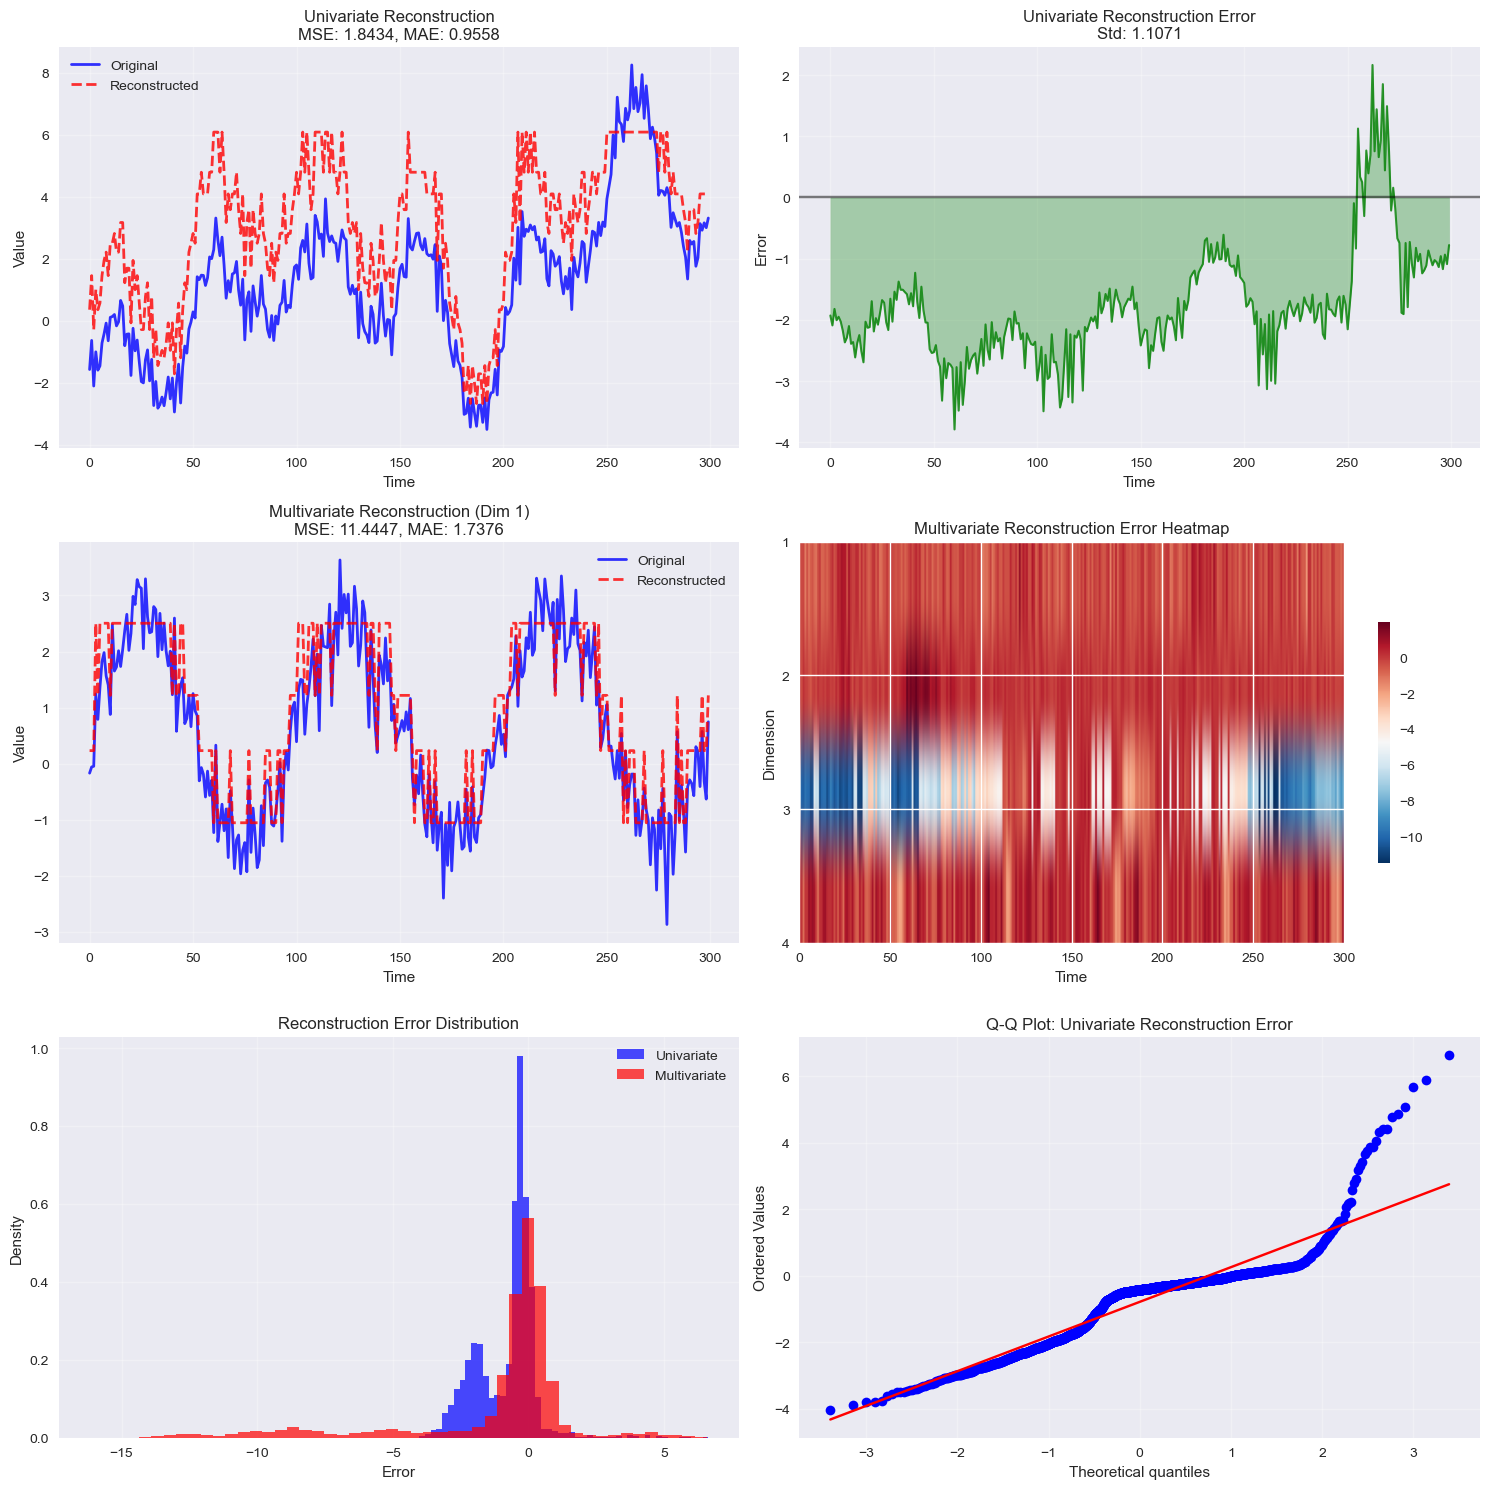


RECONSTRUCTION QUALITY ANALYSIS
Univariate Tokenization:
  Mean Squared Error: 1.843363
  Mean Absolute Error: 0.955778
  Signal-to-Noise Ratio: 5.98
  Correlation with original: 0.9214

Multivariate Tokenization:
  Mean Squared Error: 11.444709
  Mean Absolute Error: 1.737565
  Signal-to-Noise Ratio: 2.98
  Dimension 1 correlation: 0.9375
  Dimension 2 correlation: 0.9072
  Dimension 3 correlation: 0.6715
  Dimension 4 correlation: 0.9481


In [18]:
# Analyze reconstruction quality for both univariate and multivariate cases
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Univariate reconstruction
uni_decoded = np.array([tokenizer.decode(token) for token in tokens])
uni_mse = mean_squared_error(ts_complex, uni_decoded)
uni_mae = mean_absolute_error(ts_complex, uni_decoded)

# Multivariate reconstruction (decode vector codes)
mv_decoded = np.array([mv_tokenizer.decode_vector_code(code) for code in vector_codes])
mv_mse = mean_squared_error(mv_ts.flatten(), mv_decoded.flatten())
mv_mae = mean_absolute_error(mv_ts.flatten(), mv_decoded.flatten())

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Univariate reconstruction comparison
sample_range = slice(500, 800)
axes[0, 0].plot(ts_complex[sample_range], 'b-', linewidth=2, alpha=0.8, label='Original')
axes[0, 0].plot(uni_decoded[sample_range], 'r--', linewidth=2, alpha=0.8, label='Reconstructed')
axes[0, 0].set_title(f'Univariate Reconstruction\nMSE: {uni_mse:.4f}, MAE: {uni_mae:.4f}')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Univariate reconstruction error
uni_error = ts_complex - uni_decoded
axes[0, 1].plot(uni_error[sample_range], 'g-', linewidth=1.5, alpha=0.8)
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[0, 1].fill_between(range(len(uni_error[sample_range])), 
                       uni_error[sample_range], alpha=0.3, color='green')
axes[0, 1].set_title(f'Univariate Reconstruction Error\nStd: {np.std(uni_error):.4f}')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Error')
axes[0, 1].grid(True, alpha=0.3)

# Multivariate reconstruction for first dimension
axes[1, 0].plot(mv_ts[sample_range, 0], 'b-', linewidth=2, alpha=0.8, label='Original')
axes[1, 0].plot(mv_decoded[sample_range, 0], 'r--', linewidth=2, alpha=0.8, label='Reconstructed')
axes[1, 0].set_title(f'Multivariate Reconstruction (Dim 1)\nMSE: {mv_mse:.4f}, MAE: {mv_mae:.4f}')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Multivariate reconstruction error heatmap
mv_error = mv_ts - mv_decoded
im = axes[1, 1].imshow(mv_error[sample_range].T, aspect='auto', cmap='RdBu_r', 
                      extent=[0, len(mv_error[sample_range]), 4, 1])
axes[1, 1].set_title('Multivariate Reconstruction Error Heatmap')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Dimension')
axes[1, 1].set_yticks([1, 2, 3, 4])
plt.colorbar(im, ax=axes[1, 1], shrink=0.6)

# Error distribution analysis
axes[2, 0].hist(uni_error, bins=50, alpha=0.7, color='blue', 
               density=True, label='Univariate')
axes[2, 0].hist(mv_error.flatten(), bins=50, alpha=0.7, color='red', 
               density=True, label='Multivariate')
axes[2, 0].set_title('Reconstruction Error Distribution')
axes[2, 0].set_xlabel('Error')
axes[2, 0].set_ylabel('Density')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Quantile-Quantile plot for error analysis
from scipy import stats
stats.probplot(uni_error, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title('Q-Q Plot: Univariate Reconstruction Error')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary of reconstruction quality
print("\n" + "="*60)
print("RECONSTRUCTION QUALITY ANALYSIS")
print("="*60)
print(f"Univariate Tokenization:")
print(f"  Mean Squared Error: {uni_mse:.6f}")
print(f"  Mean Absolute Error: {uni_mae:.6f}")
print(f"  Signal-to-Noise Ratio: {np.var(ts_complex) / np.var(uni_error):.2f}")
print(f"  Correlation with original: {np.corrcoef(ts_complex, uni_decoded)[0,1]:.4f}")
print(f"\nMultivariate Tokenization:")
print(f"  Mean Squared Error: {mv_mse:.6f}")
print(f"  Mean Absolute Error: {mv_mae:.6f}")
print(f"  Signal-to-Noise Ratio: {np.var(mv_ts) / np.var(mv_error):.2f}")
for i in range(4):
    corr = np.corrcoef(mv_ts[:, i], mv_decoded[:, i])[0,1]
    print(f"  Dimension {i+1} correlation: {corr:.4f}")
print("="*60)

## Summary

This enhanced notebook demonstrates:

### Advanced Visualizations:
- **Adaptive Statistics Overlay**: Shows how running mean and variance evolve during streaming
- **Token Transition Analysis**: Heatmaps showing temporal dependencies in tokenization
- **PCA Analysis**: Principal component analysis of both original and tokenized representations
- **t-SNE Embeddings**: Non-linear dimensionality reduction revealing hidden structure
- **Clustering Analysis**: K-means clustering in token space with silhouette analysis

### Information Theory Metrics:
- Shannon entropy and information efficiency
- Compression ratio analysis
- Per-dimension entropy decomposition

### Reconstruction Quality:
- MSE, MAE, and correlation analysis
- Signal-to-noise ratio calculations
- Error distribution analysis with Q-Q plots

These visualizations help understand:
1. How well the tokenizer captures the underlying structure
2. The trade-offs between compression and information preservation
3. The quality of reconstruction from tokenized representations
4. The temporal dynamics and clustering properties in token space